# 6.2 Sailingyacht in a gust
![](https://yachtsandyachting.telegraph.co.uk/wp-content/uploads/media/yn14d4-581.jpg)

In [1]:
import pandas as pd
from mms185 import simpson
from mms185.sympy import lambdify,run
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

import numpy as np
from numpy import arctan,tan, sin, cos
from sympy import symbols, Eq
import sympy as sp
import pandas as pd
from sympy import Eq,symbols
from mms185.sympy import lambdify,run
from mms185.helpers import interpolate
from scipy.integrate import cumtrapz

In [2]:
meta_data = {
    'Delta':46.7,  # [t]
    'GM':0.5,  # [m]
    'mass':46.7,  # [t]
}


In [3]:
WHL,phi,mass,t_m = symbols("WHL,phi,Delta,t_m")

In [4]:
eq_WHL = Eq(WHL,9*sp.cos(phi)*t_m/mass)
eq_WHL

Eq(WHL, 9*t_m*cos(phi)/Delta)

In [5]:
eq_t_m = Eq(t_m, sp.solve(eq_WHL.subs(phi,0),t_m)[0])
eq_t_m

Eq(t_m, Delta*WHL/9)

In [6]:
lambdify(eq_t_m)

<function _lambdifygenerated(WHL, Delta)>

In [7]:
meta_data['t_m'] = run(lambdify(eq_t_m),meta_data,WHL=0.193)

In [8]:
df = pd.DataFrame()
df['phi_deg'] = [0, 10,20,30,40,50,60]
df['MS'] = np.array([0, -3, -14, -35, -76, -161, -263,])/1000  # [m]
df['phi']=np.deg2rad(df['phi_deg'])
df.set_index('phi_deg',inplace=True)

df['WHL'] = run(lambdify(eq_WHL), df, **meta_data)
df

,MS,phi,WHL
phi_deg,,,
0,0.000,0.000000,0.193000
10,-0.003,0.174533,0.190068
20,-0.014,0.349066,0.181361
30,-0.035,0.523599,0.167143
40,-0.076,0.698132,0.147847
50,-0.161,0.872665,0.124058
60,-0.263,1.047198,0.096500


### Calculate the GZ-curve

In [ ]:
df['GZ'] = ...

In [75]:
# %load GZ.py
df['GZ'] = df['MS'] + meta_data['GM']*sin(df['phi'])

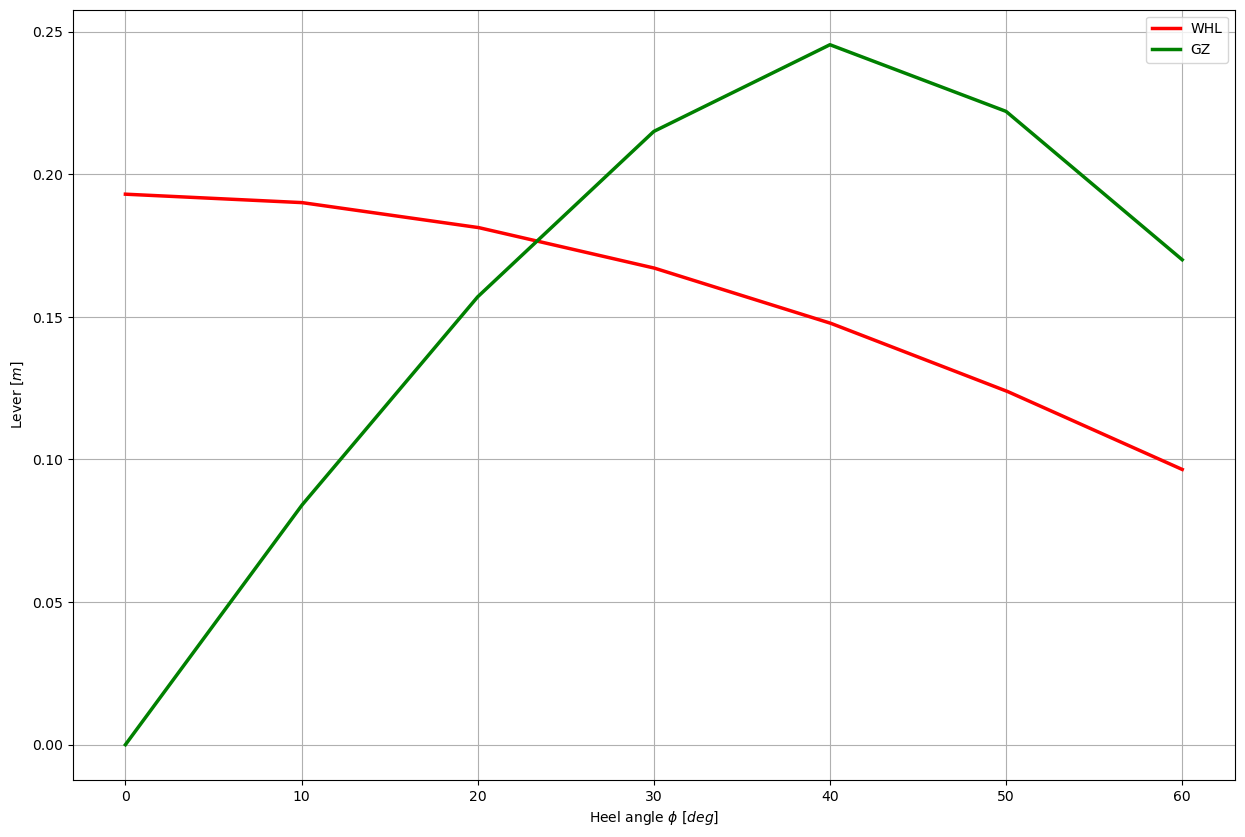

In [13]:
df_plot = interpolate(df=df)
fig,ax=plt.subplots()
df_plot.plot(y=['WHL','GZ'],color=['r','g'], lw=2.5, ax=ax)

ax.grid(True)
ax.set_xlabel(f"Heel angle $\phi$ $[deg]$")
ax.set_ylabel(f"Lever $[m]$");

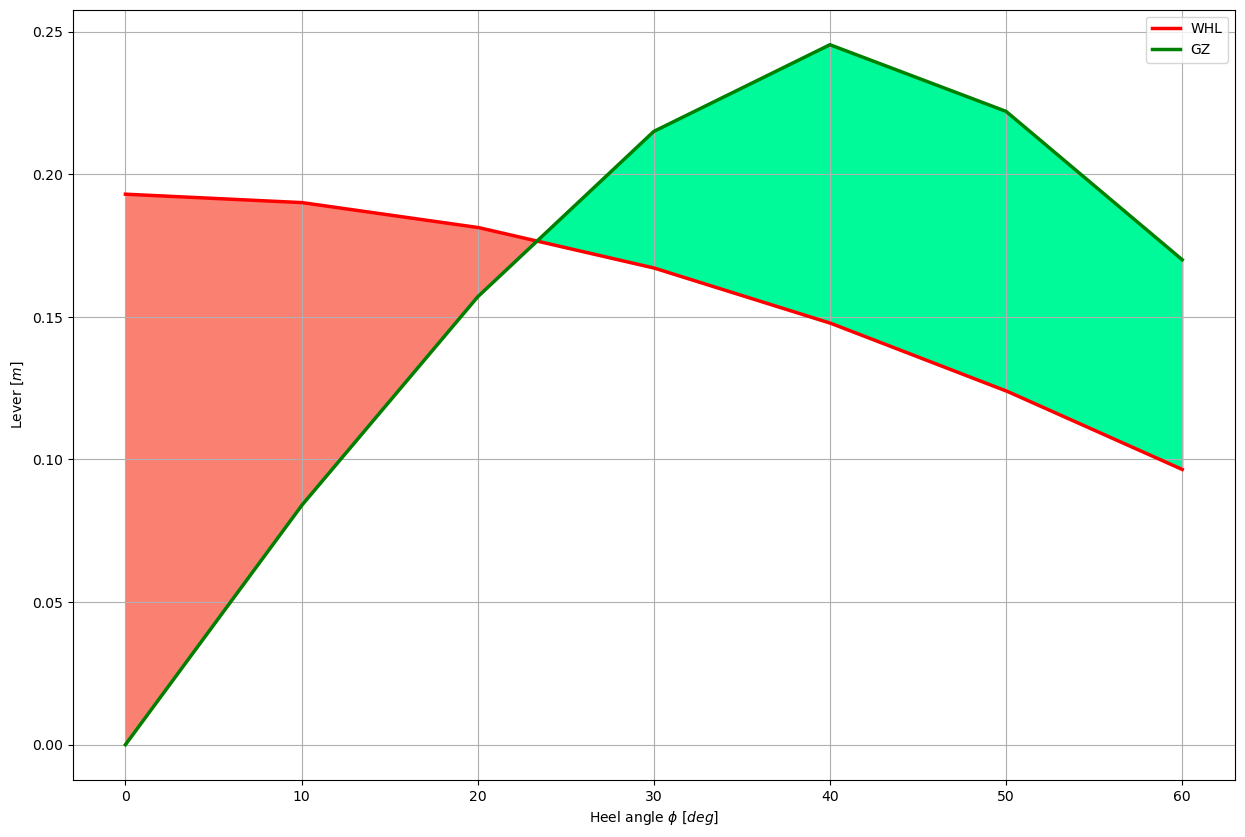

In [10]:
df_plot = interpolate(df=df)
fig,ax=plt.subplots()
df_plot.plot(y=['WHL','GZ'],color=['r','g'], lw=2.5, ax=ax)

mask = df_plot['WHL'] > df_plot['GZ']
df_ = df_plot.loc[mask]
ax.fill_between(df_.index,y1=df_['WHL'],y2=df_['GZ'], color='salmon')

mask = df_plot['WHL'] < df_plot['GZ']
df_ = df_plot.loc[mask]
ax.fill_between(df_.index,y1=df_['WHL'],y2=df_['GZ'], color='mediumspringgreen')

ax.grid(True)
ax.set_xlabel(f"Heel angle $\phi$ $[deg]$")
ax.set_ylabel(f"Lever $[m]$");

## Calculate dynamic stability lever

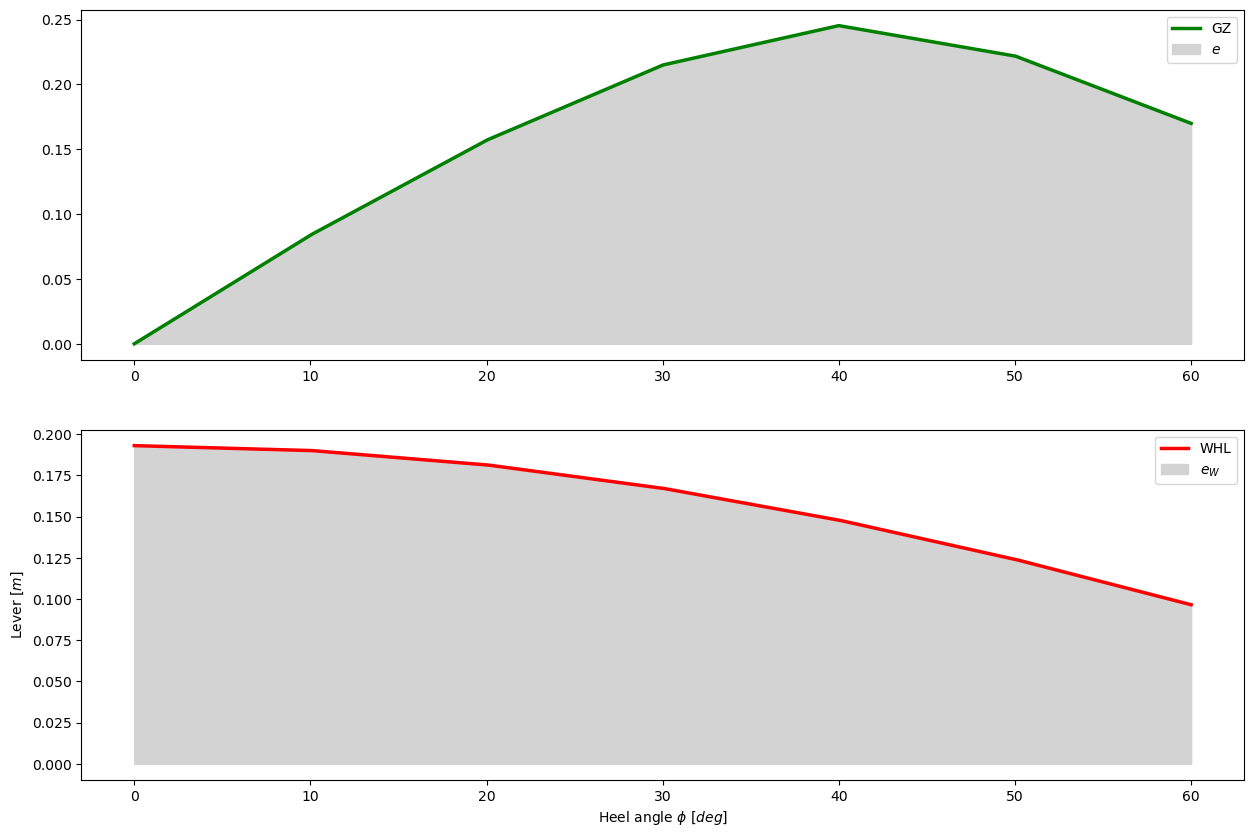

In [38]:
fig,axes=plt.subplots(nrows=2)
ax=axes[0]
df_plot.plot(y=['GZ'],color=['g'], lw=2.5, ax=ax)
ax.fill_between(df_plot.index,y1=0,y2=df_plot['GZ'], color='lightgrey', label=r'$e$')
ax.legend()

ax=axes[1]
df_plot.plot(y=['WHL'],color=['r'], lw=2.5, ax=ax)
ax.fill_between(df_plot.index,y1=0,y2=df_plot['WHL'], color='lightgrey', label=r'$e_{W}$')
ax.legend()

ax.set_xlabel(f"Heel angle $\phi$ $[deg]$")
ax.set_ylabel(f"Lever $[m]$");

In [21]:
e,GZ = symbols("e,GZ")
eq_e = Eq(e, sp.Integral(GZ,(phi,0,phi)))
eq_e

Eq(e, Integral(GZ, (phi, 0, phi)))

In [22]:
W = symbols("W")
eq_W = Eq(W,mass*e)
eq_W

Eq(W, Delta*e)

In [15]:
df['e'] = np.concatenate(([0],cumtrapz(df['GZ'], x=df['phi'])))
df['W'] = df['e']*meta_data['mass']

In [16]:
df['W_W'] = np.concatenate(([0],cumtrapz(df['WHL'], x=df['phi'])))*meta_data['mass']

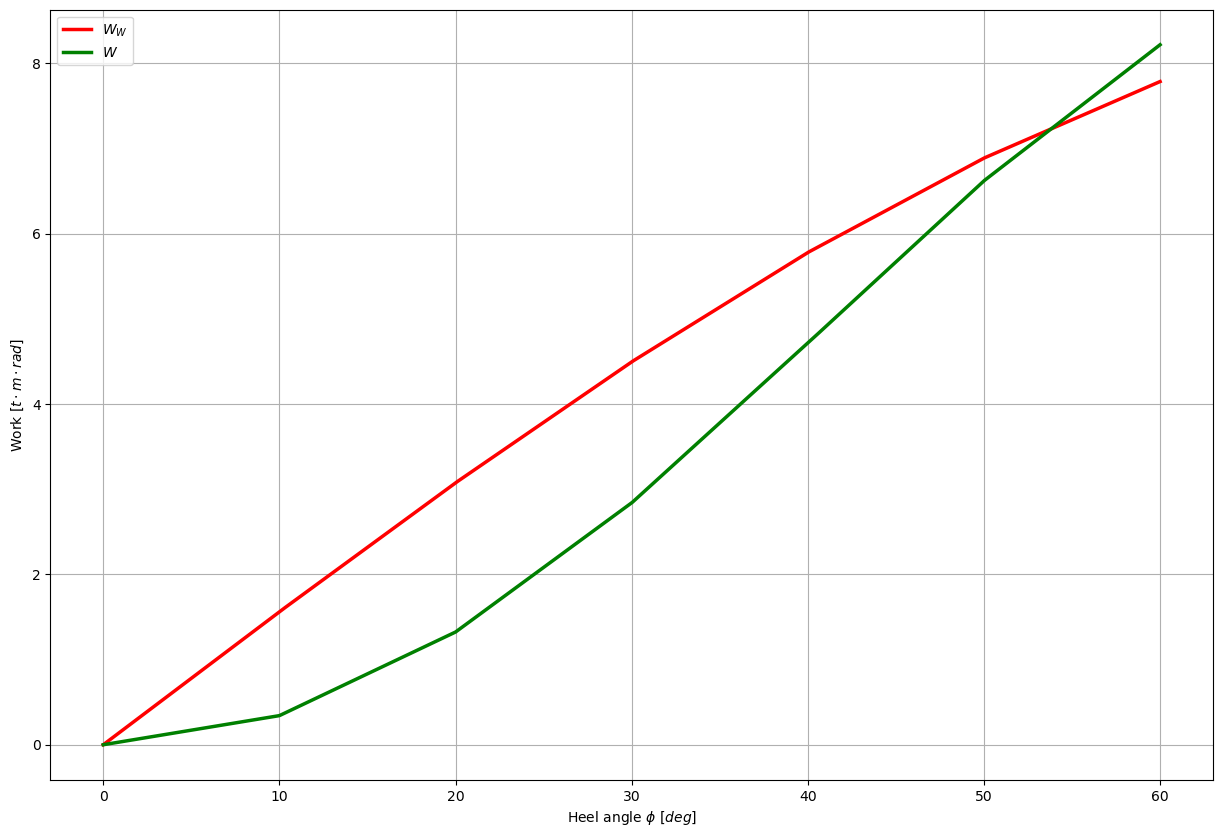

In [17]:
df_plot = interpolate(df=df)
fig,ax=plt.subplots()
df_plot.plot(y=['W_W','W'],color=['r','g'], label=[r'$W_W$',r'$W$'], lw=2.5, ax=ax)

ax.grid(True)
ax.set_xlabel(r"Heel angle $\phi$ $[deg]$")
ax.set_ylabel(r"Work $[t \cdot m \cdot rad]$");

## What is the maximum heeling angle during the gust?

## Maximum static heel angle when the wind lingers?

(0.0, 0.24539380484326961)

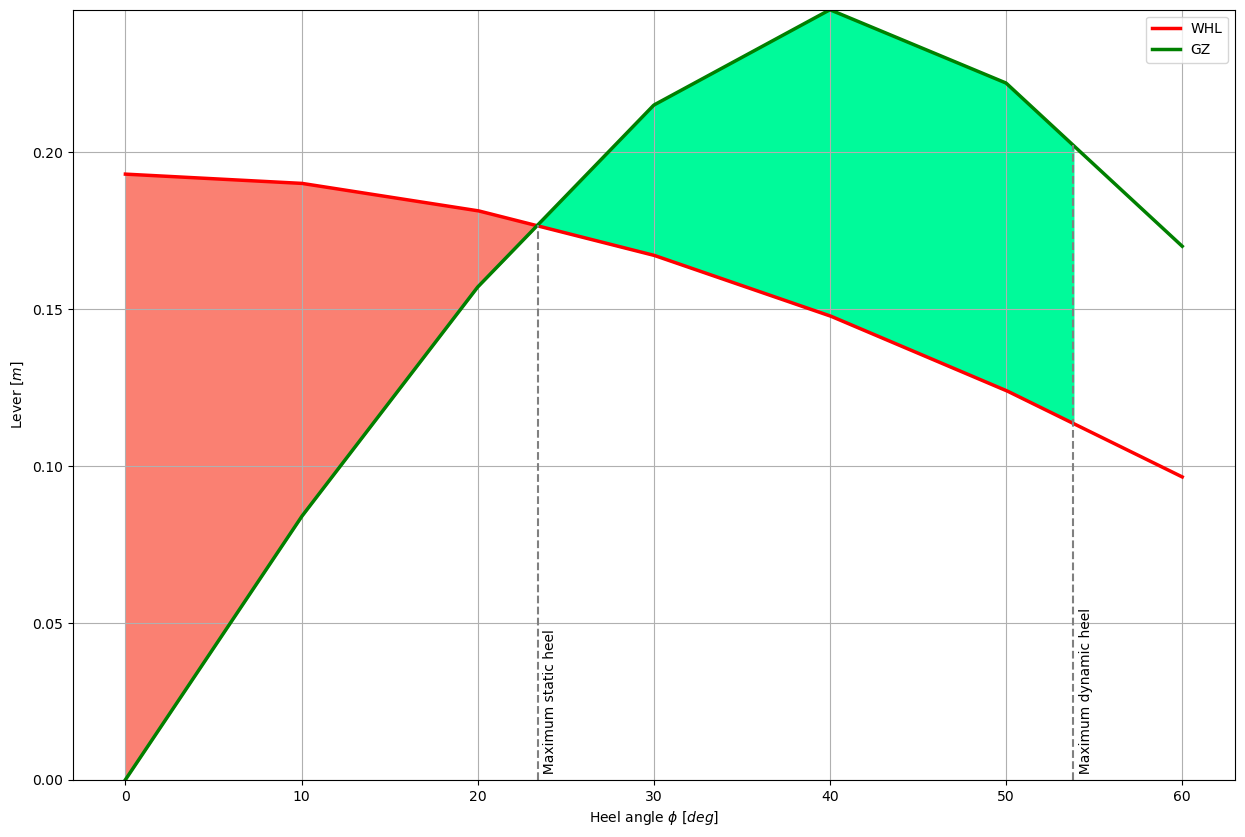

In [73]:
fig,ax=plt.subplots()
df_plot.plot(y=['WHL','GZ'],color=['r','g'], lw=2.5, ax=ax)

mask = df_plot['WHL'] > df_plot['GZ']
df_ = df_plot.loc[mask]
ax.fill_between(df_.index,y1=df_['WHL'],y2=df_['GZ'], color='salmon')

mask = ((df_plot['WHL'] < df_plot['GZ']) & (df_plot['W_W'] > df_plot['W']))
df_ = df_plot.loc[mask]
ax.fill_between(df_.index,y1=df_['WHL'],y2=df_['GZ'], color='mediumspringgreen')

ax.vlines(x=df_.index[0],ymin=0,ymax=df_.iloc[0]['GZ'], linestyles='--', color='grey')
ax.annotate("  Maximum static heel",(df_.index[0]+0.3,0), rotation=90)

ax.vlines(x=df_.index[-1],ymin=0,ymax=df_.iloc[-1]['GZ'], linestyles='--', color='grey')
ax.annotate("  Maximum dynamic heel",(df_.index[-1]+0.3,0), rotation=90)

ax.grid(True)
ax.set_xlabel(f"Heel angle $\phi$ $[deg]$")
ax.set_ylabel(f"Lever $[m]$")
ax.set_ylim(0,df['GZ'].max())